This is the base where we dont use any edgeweights at all.
Vanilla dataset

In [1]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

In [2]:

# import os
# !pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)
# #torch_version = '2.0.0+cu118'
# #!pip install torch-scatter -f https://data.pyg.org/whl/torch-${torch.__version__}.html
# #!pip install torch-cluster -f https://data.pyg.org/whl/torch-${torch.__version__}.html
# #!pip install torch-sparse -f https://data.pyg.org/whl/torch-${torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu121.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu121.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install sentence-transformers
# !pip install torcheval
# !pip install matplotlib
# !pip install pandas
# !pip install tensorboard

In [3]:
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

/home/amos/mambaforge/envs/pyg_torch21/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

dataset_files = [
    'final_courses_and_programs',
    'final_qualifications',
    'final_skills',

    'final_qualification_skill_edges',
    'final_course_and_program_skill_edges',
    'final_course_qualification_edges',

    'final_course_and_programs_student_edges',

    'final_people',
    'final_jobs',
    'final_organizations',
    'final_job_student_edges',
    'final_supervisor_supervisee_edges',
    'final_organization_student_edges',
    'fixed_job_job_edges',
    'fixed_job_skill_edges',
    'fixed_broader_job_job_edges'
    #'job_skill_edges_tfidf_100mio_50kid_800kskill'
]
df_names= []
for name in dataset_files:
    df = pd.read_csv('final_dataset_courseprograms_joined/'+name+'.csv', lineterminator='\n')
    print(name, df.shape[0])
    globals()[name.replace('final_','').replace('fixed_','')] = df
    df_names.append(name.replace('final_','').replace('fixed_',''))
    
import string
word_list = [
    "or", "up", "it", "us", "race", "location", "systems", "tools",
    "so", "addition", "id", "am", "edge"
] + list(set(list(string.ascii_lowercase))-set(['r']))
job_skill_edges = job_skill_edges.loc[~job_skill_edges['skill'].isna()]
job_skill_edges = job_skill_edges.loc[~job_skill_edges['skill'].isin(word_list)]


# filter out all skills if the whole skill is a number only
job_skill_edges = job_skill_edges.loc[~ job_skill_edges['skill'].str.isnumeric()]
print('job_skill_edges', job_skill_edges.shape[0])



course_and_program_skill_edges = course_and_program_skill_edges.loc[~course_and_program_skill_edges['Skill'].isna()]
skills = skills.loc[~skills['SKILL'].isna()]

# convert create_dte to timestamp if it is not already
x  = pd.to_datetime(courses_and_programs['CREATE_DTE'], unit='s', errors='coerce')
courses_and_programs.loc[~x.isna(), 'CREATE_DTE'] = x



courses_and_programs.loc[courses_and_programs['TITLE'].isna(), 'TITLE'] = ''
courses_and_programs.loc[courses_and_programs['DESCRIPTION'].isna(), 'DESCRIPTION'] = ''
qualifications.loc[qualifications['TITLE'].isna(), 'TITLE'] = ''
qualifications.loc[qualifications['DESCRIPTION'].isna(), 'DESCRIPTION'] = ''

/tmp/ipykernel_2892/3933947480.py:25: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_dataset_courseprograms_joined/'+name+'.csv', lineterminator='\n')


final_courses_and_programs 65455
final_qualifications 1475
final_skills 872043
final_qualification_skill_edges 1598
final_course_and_program_skill_edges 260381
final_course_qualification_edges 2099
final_course_and_programs_student_edges 553629
final_people 293444
final_jobs 55653
final_organizations 13613
final_job_student_edges 293444
final_supervisor_supervisee_edges 217922
final_organization_student_edges 292060
fixed_job_job_edges 18384
fixed_job_skill_edges 16589018
fixed_broader_job_job_edges 54586
job_skill_edges 16289586


In [5]:
# add some skills which are only in the job_skill_edges but not in the skills csv
a = set(job_skill_edges['skill'].unique())
b = set(skills['SKILL'].unique())

skills_to_add = list(a-b)
skills_to_add = pd.DataFrame({'SKILL':skills_to_add})
skills = pd.concat([skills, skills_to_add], axis=0)
skills = skills.reset_index(drop=True)

/tmp/ipykernel_2892/2933620897.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  job_skill_edges_grouped = job_skill_edges.groupby('JOB_ID').median()


<Axes: >

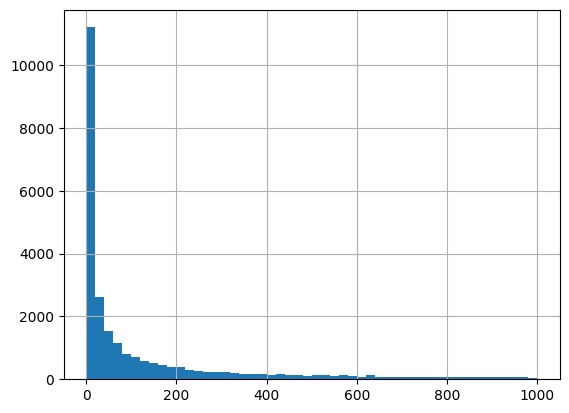

In [6]:
# group by JOB_ID
job_skill_edges_grouped = job_skill_edges.groupby('JOB_ID').median()
job_skill_edges_grouped

# plot hist for n_jobdesc_used
job_skill_edges_grouped['n_jobdesc_used'].hist(bins=50, range=(0,1000))

In [7]:
# filter out jobs with less than 10 job descriptions
#job_skill_edges = job_skill_edges.loc[job_skill_edges['n_jobdesc_used']>=6]

In [8]:
# import pandas as pd
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming 'job_skill_edges' is your DataFrame with the column 'scaled_tfidf'

# # Calculate the threshold value (95th percentile)
# threshold = np.percentile(job_skill_edges['scaled_tfidf'], 5)

# # Replace values above the threshold with the threshold value
# #job_skill_edges.loc[job_skill_edges['scaled_tfidf'] > threshold, 'scaled_tfidf'] = threshold

# # Plot the KDE and threshold
# sns.kdeplot(data=job_skill_edges['scaled_tfidf'])
# plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
# plt.legend()
# plt.xlabel('scaled_tfidf')
# plt.ylabel('Density')
# plt.title('Kernel Density Estimation')
# plt.show()

In [9]:
# for each df in df_names print the name and print the columns containing nans
for name in df_names:
    print(name)
    print(globals()[name].columns[globals()[name].isna().any()].tolist())


courses_and_programs
[]
qualifications
[]
skills
[]
qualification_skill_edges
[]
course_and_program_skill_edges
[]
course_qualification_edges
[]
course_and_programs_student_edges
[]
people
[]
jobs
[]
organizations
[]
job_student_edges
[]
supervisor_supervisee_edges
[]
organization_student_edges
[]
job_job_edges
[]
job_skill_edges
[]
broader_job_job_edges
['Short Title']


In [10]:
del broader_job_job_edges['Short Title']
broader_job_job_edges = broader_job_job_edges[['index_fixed','onet_index_fixed']]
broader_job_job_edges['SRC_ID'] = broader_job_job_edges['index_fixed']
broader_job_job_edges['DST_ID'] = broader_job_job_edges['onet_index_fixed']
del broader_job_job_edges['index_fixed']
del broader_job_job_edges['onet_index_fixed']

/tmp/ipykernel_2892/4011874702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broader_job_job_edges['SRC_ID'] = broader_job_job_edges['index_fixed']
/tmp/ipykernel_2892/4011874702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broader_job_job_edges['DST_ID'] = broader_job_job_edges['onet_index_fixed']


In [11]:

# for each column which contains DTE DATE or Date or date, convert the column to timestamp, for all dfs in df_names, save the highest timestamp overall to timestamp_max
cols_dte = []
timestamp_max = 0
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if 'DTE' in col or 'DATE' in col or 'Date' in col or 'date' in col:
            try:

                globals()[name][col] = (pd.to_datetime(globals()[name][col]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
                timestamp_max = max(timestamp_max, globals()[name][col].max())
                cols_dte.append(col)
                print('>>> converted',col)
            except:
                print('could not convert', col)
                pass

# normalize all timestamps by timestamp max
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if 'DTE' in col or 'DATE' in col or 'Date' in col or 'date' in col:
            try:
                globals()[name][col] = globals()[name][col] / timestamp_max
            except:
                print('could not convert', col)
                pass



courses_and_programs
>>> converted REV_DTE
>>> converted CREATE_DTE
qualifications
>>> converted CREATE_DTE
skills
qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
>>> converted COMPL_DTE
>>> converted ASSGN_DTE
people
>>> converted HIRE_DTE
jobs
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges
courses_and_programs
qualifications
skills
qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
people
jobs
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges


In [12]:
# get all columns not in DTE DATE or Date or date, for all df_names, if the first 20 rows of the column are not numeric, normalize the column by the max of the column
cols_numeric = []
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if col not in cols_dte and 'DTE' not in col and 'DATE' not in col and 'Date' not in col and 'date' not in col and 'ID' not in col and 'index' not in col and 'alt_title' not in col:
            if 'TOTAL' in col:
                print(col)
            try:
                if not pd.to_numeric(globals()[name][col], errors='coerce').isna().any():
                    globals()[name][col] = pd.to_numeric(globals()[name][col]) / pd.to_numeric(globals()[name][col]).max()
                    print('>>> converted', col)
                    cols_numeric.append(col)
                    
                else:
                    print('--- did not convert', col)
            except:
                print('could not convert', col)
                pass
            

courses_and_programs
--- did not convert NOTACTIVE
TOTAL_RATING
>>> converted TOTAL_RATING
>>> converted AVG_RATING
--- did not convert CPNT_CLASSIFICATION
>>> converted CREDIT_HRS
--- did not convert THUMBNAIL_URI
--- did not convert TITLE
--- did not convert TITLE_TRANSLATION_NEEDED
--- did not convert DESC_TRANSLATION_NEEDED
--- did not convert DESCRIPTION
--- did not convert LEARNING_TYPE
qualifications
--- did not convert NOTACTIVE
--- did not convert TITLE
--- did not convert TITLE_TRANSLATION_NEEDED
--- did not convert DESC_TRANSLATION_NEEDED
--- did not convert DESCRIPTION
skills
--- did not convert SKILL
qualification_skill_edges
--- did not convert Skill
could not convert IS_APPROXIMATE
course_and_program_skill_edges
--- did not convert Skill
could not convert IS_APPROXIMATE
course_qualification_edges
course_and_programs_student_edges
>>> converted TOOK_MINUTES
people
--- did not convert IS_ACTIVE_INFERRED
--- did not convert FULLTIME
jobs
--- did not convert TITLE
--- did no

In [13]:
# for all columns not in col_dte and cols_numeric, if the column only contains unique values, save it to cols_id
cols_id = []
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if col not in cols_dte and col not in cols_numeric:
            if len(globals()[name][col].unique()) == globals()[name].shape[0] or '_ID' in col or 'index_x' in col or 'index_y' in col:
                cols_id.append(col)
                print('>>> ID col', col)
            else:
                print(col)

courses_and_programs
NOTACTIVE
CPNT_CLASSIFICATION
>>> ID col CPNT_TYP_ID
>>> ID col DMN_ID
>>> ID col CPNT_SRC_ID
THUMBNAIL_URI
TITLE
TITLE_TRANSLATION_NEEDED
DESC_TRANSLATION_NEEDED
DESCRIPTION
LEARNING_TYPE
>>> ID col REAL_ID
>>> ID col LEARNING_ITEM_ID
qualifications
NOTACTIVE
>>> ID col QUAL_TYP_ID
>>> ID col DMN_ID
TITLE
TITLE_TRANSLATION_NEEDED
DESC_TRANSLATION_NEEDED
DESCRIPTION
>>> ID col REAL_ID
>>> ID col LEARNING_ITEM_ID
>>> ID col QUAL_ID
skills
SKILL
qualification_skill_edges
Skill
IS_APPROXIMATE
>>> ID col LEARNING_ITEM_ID
course_and_program_skill_edges
Skill
IS_APPROXIMATE
>>> ID col LEARNING_ITEM_ID
course_qualification_edges
>>> ID col LEARNING_ITEM_ID
>>> ID col QUAL_ID
course_and_programs_student_edges
>>> ID col LEARNING_ITEM_ID
>>> ID col STUD_ID
people
>>> ID col EMP_TYP_ID
IS_ACTIVE_INFERRED
FULLTIME
>>> ID col DMN_ID
>>> ID col STUD_ID
jobs
>>> ID col TITLE
O*NET-SOC Code
>>> ID col ID
organizations
>>> ID col ORG_ID
job_student_edges
>>> ID col ONET_ID
>>> ID 

In [14]:
# for all columns not in col_dte and cols_numeric and cols_id, if the column only contains 2 different values, save it to cols_binary and encode the column to 0 and 1
cols_binary = []
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if col not in cols_dte and col not in cols_numeric and col not in cols_id:
            if len(globals()[name][col].unique()) == 2:
                cols_binary.append(col)
                print('>>> binary col', col)
                globals()[name][col] = globals()[name][col].astype('category').cat.codes
            else:
                print(col)

courses_and_programs
>>> binary col NOTACTIVE
CPNT_CLASSIFICATION
THUMBNAIL_URI
>>> binary col TITLE_TRANSLATION_NEEDED
>>> binary col DESC_TRANSLATION_NEEDED
DESCRIPTION
LEARNING_TYPE
qualifications
>>> binary col NOTACTIVE
>>> binary col TITLE_TRANSLATION_NEEDED
>>> binary col DESC_TRANSLATION_NEEDED
DESCRIPTION
skills
SKILL
qualification_skill_edges
Skill
>>> binary col IS_APPROXIMATE
course_and_program_skill_edges
Skill
>>> binary col IS_APPROXIMATE
course_qualification_edges
course_and_programs_student_edges
people
IS_ACTIVE_INFERRED
>>> binary col FULLTIME
jobs
O*NET-SOC Code
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
O*NET-SOC Code
Title
Related O*NET-SOC Code
Related Title
Relatedness Tier
job_skill_edges
skill
broader_job_job_edges


In [15]:
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        print('  ', col)

courses_and_programs
   NOTACTIVE
   REV_DTE
   CREATE_DTE
   TOTAL_RATING
   AVG_RATING
   CPNT_CLASSIFICATION
   CPNT_TYP_ID
   DMN_ID
   CPNT_SRC_ID
   CREDIT_HRS
   THUMBNAIL_URI
   TITLE
   TITLE_TRANSLATION_NEEDED
   DESC_TRANSLATION_NEEDED
   DESCRIPTION
   LEARNING_TYPE
   REAL_ID
   LEARNING_ITEM_ID
qualifications
   NOTACTIVE
   CREATE_DTE
   QUAL_TYP_ID
   DMN_ID
   TITLE
   TITLE_TRANSLATION_NEEDED
   DESC_TRANSLATION_NEEDED
   DESCRIPTION
   REAL_ID
   LEARNING_ITEM_ID
   QUAL_ID
skills
   SKILL
qualification_skill_edges
   Skill
   IS_APPROXIMATE
   LEARNING_ITEM_ID
course_and_program_skill_edges
   Skill
   IS_APPROXIMATE
   LEARNING_ITEM_ID
course_qualification_edges
   LEARNING_ITEM_ID
   QUAL_ID
course_and_programs_student_edges
   COMPL_DTE
   ASSGN_DTE
   TOOK_MINUTES
   LEARNING_ITEM_ID
   STUD_ID
people
   EMP_TYP_ID
   IS_ACTIVE_INFERRED
   FULLTIME
   DMN_ID
   HIRE_DTE
   STUD_ID
jobs
   TITLE
   O*NET-SOC Code
   ID
organizations
   ORG_ID
job_student_edges
  

In [16]:
unique_domains = set()
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if 'DMN_ID' in col:
            print(col)
            unique_domains.update(globals()[name][col].unique())
            print(name, globals()[name][col].unique())
            
print('unique domain ids' , unique_domains)

# create onehot mapping for all domain ids
domain_id_to_onehot = {}
for i, domain_id in enumerate(unique_domains):
    onehot = [0] * len(unique_domains)
    onehot[i] = 1
    domain_id_to_onehot[domain_id] = onehot

# for all columns, if they are DMN_ID columns, replace the column with the onehot mapping
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if 'DMN_ID' in col:
            print(col)
            globals()[name][col] = globals()[name][col].apply(lambda x: domain_id_to_onehot[x])
            

courses_and_programs
DMN_ID
courses_and_programs ['OCN' 'SCOTIABANK' 'PUBLIC' 'IB' 'SKILLSOFT' 'INACTIVE' '5065']
qualifications
DMN_ID
qualifications ['SCOTIABANK' 'PUBLIC' 'IB']
skills
qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
people
DMN_ID
people ['SCOTIABANK' 'HIDDEN' 'MALAYSIA' 'PUBLIC']
jobs
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges
unique domain ids {'5065', 'SKILLSOFT', 'OCN', 'IB', 'SCOTIABANK', 'MALAYSIA', 'PUBLIC', 'INACTIVE', 'HIDDEN'}
courses_and_programs
DMN_ID
qualifications
DMN_ID
skills
qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
people
DMN_ID
jobs
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges


In [17]:
# in the qualification program edges, remap the qual_id to the learning item id of the qualification
# so that we dont have to remap the skill qualification edges, which use the learning item id of the qualification

qual_to_learning_id = {row.QUAL_ID:row.LEARNING_ITEM_ID for i, row in qualifications.iterrows()}


course_qualification_edges['QUAL_LEARNING_ID'] = course_qualification_edges['QUAL_ID'].apply(lambda x: qual_to_learning_id[x])
del course_qualification_edges['QUAL_ID'] 

In [18]:

cols = {
    'courses_and_programs': {
        'categorical': [
            'CPNT_TYP_ID', 'CPNT_SRC_ID', 'LEARNING_TYPE', 'CPNT_CLASSIFICATION' #, 'DMN_ID' handle dmn id separately
        ],
        'remove':[
            'REAL_ID', 
            'THUMBNAIL_URI',
            'TITLE_TRANSLATION_NEEDED',
            'DESCRIPTION_TRANSLATION_NEEDED',
            'DESC_TRANSLATION_NEEDED',
            'NOTACTIVE'
        ],
        'text': [
            'TITLE', 'DESCRIPTION'
        ]
    },
    'qualifications': {
        'categorical': [
            'QUAL_TYP_ID', # 'DMN_ID' handle dmn id separately
        ],
        'remove':[
            'REAL_ID', 
            'TITLE_TRANSLATION_NEEDED',
            'DESCRIPTION_TRANSLATION_NEEDED',
            'DESC_TRANSLATION_NEEDED',
            'NOTACTIVE',
            #"LEARNING_ITEM_ID"
            'QUAL_ID'
        ],
        'text': [
            'TITLE', 'DESCRIPTION'
        ]
    },
    'skills':{
        'text':['SKILL']
    },
    'jobs':{
        'remove':[
            'O*NET-SOC Code', 
        ],
        'text':['TITLE']
    },
     'job_job_edges':{
        'remove':[
            'O*NET-SOC Code', 
            'Related O*NET-SOC Code',
            'Title',
            'Related Title'
            
        ],
    },
     'job_skill_edges':{
        'remove':[
            'n_jobdesc_used'
            
        ],
    },
     'qualification_skill_edges':{
        'remove':[
            'IS_APPROXIMATE'
            
        ]
        
    },
      'course_and_program_skill_edges':{
        'remove':[
            'IS_APPROXIMATE'
            
        ]
        
    },
      'people':{
          'remove':['IS_ACTIVE_INFERRED'],
          'categorical':['EMP_TYP_ID']
      }
    
}
# for all columns in cols, if the column is in the df, remove the column from the df
for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if name in cols.keys() and 'remove' in cols[name].keys() and col in cols[name]['remove']:
            print('>>> remove', col)
            
            globals()[name] = globals()[name].drop(col, axis=1)

courses_and_programs
>>> remove NOTACTIVE
>>> remove THUMBNAIL_URI
>>> remove TITLE_TRANSLATION_NEEDED
>>> remove DESC_TRANSLATION_NEEDED
>>> remove REAL_ID
qualifications
>>> remove NOTACTIVE
>>> remove TITLE_TRANSLATION_NEEDED
>>> remove DESC_TRANSLATION_NEEDED
>>> remove REAL_ID
>>> remove QUAL_ID
skills
qualification_skill_edges
>>> remove IS_APPROXIMATE
course_and_program_skill_edges
>>> remove IS_APPROXIMATE
course_qualification_edges
course_and_programs_student_edges
people
>>> remove IS_ACTIVE_INFERRED
jobs
>>> remove O*NET-SOC Code
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
>>> remove O*NET-SOC Code
>>> remove Title
>>> remove Related O*NET-SOC Code
>>> remove Related Title
job_skill_edges
>>> remove n_jobdesc_used
broader_job_job_edges


In [19]:
# for all dfs for all columns, if col in cols and categorical in cols[name] and col in df, convert the column to onehot categories
onehot_and_numeric_mappings = {}
for name in df_names:
    print(name)
    onehot_and_numeric_mappings[name] = {}
    for col in globals()[name].columns:
        if name in cols.keys() and 'categorical' in cols[name].keys() and col in cols[name]['categorical']:
            print('>>> categorical', col)
            unique_categories = globals()[name][col].unique()
            to_onehot = {}
            for i, category in enumerate(unique_categories):
                onehot = [0] * len(unique_categories)
                onehot[i] = 1
                to_onehot[category] = onehot
                
            globals()[name][col] = globals()[name][col].apply(lambda x: to_onehot[x])
            print(name, col, 'categories:',str(to_onehot))
            onehot_and_numeric_mappings[name][col] = to_onehot
            
            
job_job_edges['Relatedness Tier'] = job_job_edges['Relatedness Tier'].apply(lambda x: {'Primary-Short':1,'Primary-Long':0.75, 'Supplemental':0.5}[x])
onehot_and_numeric_mappings['job_job_edges'] = {'Relatedness Tier':{'Primary-Short':1,'Primary-Long':0.75, 'Supplemental':0.5}}

courses_and_programs
>>> categorical CPNT_CLASSIFICATION
courses_and_programs CPNT_CLASSIFICATION categories: {'CONTINUOUS ONLINE ACCESS': [1, 0, 0, 0, 0, 0], 'TIME-BASED': [0, 1, 0, 0, 0, 0], 'EXTERNAL-COURSE': [0, 0, 1, 0, 0, 0], 'PHYSICAL GOOD': [0, 0, 0, 1, 0, 0], 'BLENDED': [0, 0, 0, 0, 1, 0], 'PROGRAM': [0, 0, 0, 0, 0, 1]}
>>> categorical CPNT_TYP_ID
courses_and_programs CPNT_TYP_ID categories: {'WBT': [1, 0, 0, 0, 0, 0, 0], 'ILT': [0, 1, 0, 0, 0, 0, 0], 'SKILLASSESSMENT': [0, 0, 1, 0, 0, 0, 0], 'OJT': [0, 0, 0, 1, 0, 0, 0], 'CRSE': [0, 0, 0, 0, 1, 0, 0], 'VC': [0, 0, 0, 0, 0, 1, 0], 'SYSTEM_PROGRAM_ENTITY': [0, 0, 0, 0, 0, 0, 1]}
>>> categorical CPNT_SRC_ID
courses_and_programs CPNT_SRC_ID categories: {'PLURALSIGHT': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'CSI': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Scotiabank': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'LINKEDINLEARNING': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'UNKNOWN': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'VIDYARD': [0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [20]:
# for all text columns apply all-mpnet-base-v2 sentence embeddings
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
# for name in df_names:
#     print(name)
#     for col in globals()[name].columns:
#         if name in cols.keys() and 'text' in cols[name].keys() and col in cols[name]['text']:
#             if col =='DESCRIPTION':
#                 # skip 
#                 continue 
            
#             print('>>> text col, apply mpnet', col)
            
#             # save to pickle and if it already exists, load from pickle 
#             pickle_path = 'final_dataset_courseprograms_joined/'+name+'_'+col+'_mpnet.pkl'
#             if os.path.exists(pickle_path):
#                 if col == 'TITLE':
#                     globals()[name]['TEXT_EMBEDDING'] = pd.read_pickle(pickle_path)
#                 else:
#                     globals()[name][col] = pd.read_pickle(pickle_path)
#             else:
#                 if col == 'TITLE': # combine Title and Description
#                     globals()[name]['TEXT_EMBEDDING'] = globals()[name]['TITLE'] + '\n' + globals()[name]['DESCRIPTION']
#                     globals()[name]['TEXT_EMBEDDING'] = globals()[name]['TEXT_EMBEDDING'].apply(lambda x: model.encode(x))
#                 else:
#                     globals()[name][col] = globals()[name][col].apply(lambda x: model.encode(x))
                    
#                 globals()[name][col].to_pickle(pickle_path)
       
            

In [21]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np
import os

model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

batch_size = 1000  # Specify your batch size

for name in df_names:
    print(name)
    for col in globals()[name].columns:
        if name in cols.keys() and 'text' in cols[name].keys() and col in cols[name]['text']:
            if col =='DESCRIPTION':
                # skip 
                continue 
            
            print('>>> text col, apply mpnet', col)
            
            # save to pickle and if it already exists, load from pickle 
            pickle_path = 'final_dataset_courseprograms_joined/'+name+'_'+col+'_mpnet.pkl'
            if os.path.exists(pickle_path):
                # if col == 'TITLE':
                #     globals()[name]['TEXT_EMBEDDING'] = pd.read_pickle(pickle_path)
                # else:
                globals()[name]['TEXT_EMBEDDING'] = pd.read_pickle(pickle_path)
            else:
                num_batches = int(np.ceil(len(globals()[name][col]) / batch_size))
                embeddings = []
                
                if col == 'TITLE' and name !='jobs':
                    texts = globals()[name]['TITLE'] + '\n' + globals()[name]['DESCRIPTION']
                else:
                    texts = globals()[name][col]
                
                for i in tqdm(range(num_batches)):
                    batch_texts = texts[i * batch_size: (i + 1) * batch_size]
                    batch_embeddings = model.encode(batch_texts.tolist())
                    embeddings.extend(batch_embeddings)
                    
                # if col == 'TITLE' and name !='jobs':
                #     globals()[name]['TEXT_EMBEDDING'] = embeddings
                # else:
                globals()[name]['TEXT_EMBEDDING'] = embeddings

                pd.to_pickle(embeddings, pickle_path)
                
                
skills = skills.drop_duplicates(subset=['SKILL']) # don't want to recompute with the dropped list, so we drop afterwards

courses_and_programs
>>> text col, apply mpnet TITLE
qualifications
>>> text col, apply mpnet TITLE
skills
>>> text col, apply mpnet SKILL
qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
people
jobs
>>> text col, apply mpnet TITLE
organizations
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges


In [22]:
# job job remapping
# job skill remapping
# job broader job remapping



(array([5573066., 1804891., 1075701.,  748492.,  564394.,  447021.,
         367442.,  309200.,  264869.,  229667.,  203534.,  181147.,
         162844.,  148135.,  134272.,  122995.,  114135.,  105177.,
          98376.,   90941.,   84685.,   79518.,   75446.,   70618.,
          66815.,   63374.,   60872.,   57226.,   54737.,   52048.,
          49551.,   47361.,   45569.,   43633.,   41795.,   40060.,
          38525.,   37513.,   36293.,   34477.,   33413.,   32570.,
          31486.,   30369.,   29521.,   28765.,   27656.,   27195.,
          26320.,   25380.,   24565.,   24102.,   23328.,   23155.,
          22205.,   21621.,   21221.,   20842.,   20127.,   19485.,
          19331.,   18897.,   18556.,   17963.,   17568.,   17153.,
          16632.,   16519.,   16127.,   15871.,   15590.,   15329.,
          14853.,   14630.,   13981.,   14010.,   13784.,   13436.,
          13464.,   13005.,   12821.,   12662.,   12371.,   12262.,
          11688.,   11790.,   11389.,   11422., 

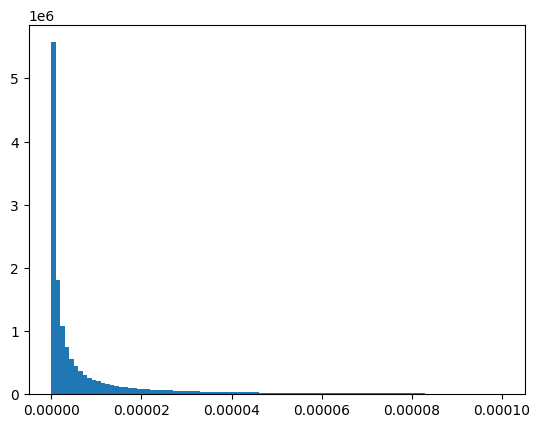

In [23]:
import matplotlib.pyplot as plt 
# plot job_skill_edges scaled_tfidf, histogram, from 0 to 1, 100 bins
plt.hist(job_skill_edges['scaled_tfidf'], bins=100, range=(0,0.0001))

In [24]:
# print all dfs in df_name if they have a name with edge in it
for name in df_names:
    if 'edge' in name:
        print(name)


qualification_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_and_programs_student_edges
job_student_edges
supervisor_supervisee_edges
organization_student_edges
job_job_edges
job_skill_edges
broader_job_job_edges


In [25]:

# rename edges so we can do automatic mapping
# for all of the below:
# qualification_skill_edges
# course_and_program_skill_edges
# course_qualification_edges
# course_and_programs_student_edges
# job_student_edges
# supervisor_supervisee_edges
# organization_student_edges
# job_job_edges
# job_skill_edges
# broader_job_job_edges
# create a dictionary which has the column renamed for each df
rename_dict = {}
rename_dict['qualification_skill_edges'] = {'LEARNING_ITEM_ID':'qualifications_id', 'Skill':'skills_id'}
rename_dict['course_and_program_skill_edges'] = {'Skill':'skills_id','LEARNING_ITEM_ID':'courses_and_programs_id'}
rename_dict['course_qualification_edges'] = {'LEARNING_ITEM_ID':'courses_and_programs_id', 'QUAL_LEARNING_ID':'qualifications_id'}
rename_dict['course_and_programs_student_edges'] = {'LEARNING_ITEM_ID':'courses_and_programs_id', 'STUD_ID':'people_id'}
rename_dict['job_student_edges'] = {'ONET_ID':'jobs_id','STUD_ID':'people_id'}
rename_dict['supervisor_supervisee_edges'] = {'STUD_ID':'people_id1', 'SUPER_ID':'people_id2'}
rename_dict['organization_student_edges'] = {'ORG_ID':'organizations_id', 'STUD_ID':'people_id'}
rename_dict['job_job_edges'] = {'SRC_ID':'jobs_id1','DST_ID':'jobs_id2'}
rename_dict['job_skill_edges'] = {'skill':'skills_id','JOB_ID':'jobs_id'}
rename_dict['broader_job_job_edges'] = {'SRC_ID':'jobs_id1','DST_ID':'jobs_id2'}

# same for the node dfs
rename_dict['courses_and_programs'] = {'LEARNING_ITEM_ID':'courses_and_programs_id'}
rename_dict['qualifications'] = {'LEARNING_ITEM_ID':'qualifications_id'}
#rename_dict['skills'] = {'SKILL':'skills_id'}
rename_dict['jobs'] = {'ID':'jobs_id'}
rename_dict['people'] = {'STUD_ID':'people_id'}
rename_dict['organizations'] = {'ORG_ID':'organizations_id'}


# rename all the columns correspondingly
for name in df_names:
    if name in rename_dict.keys():
        globals()[name] = globals()[name].rename(columns=rename_dict[name])
        


In [26]:
# print out columns for all edge types:
for name in df_names:
    if 'edge' in name:
        print(name)
        print(globals()[name].columns)

qualification_skill_edges
Index(['skills_id', 'qualifications_id'], dtype='object')
course_and_program_skill_edges
Index(['skills_id', 'courses_and_programs_id'], dtype='object')
course_qualification_edges
Index(['courses_and_programs_id', 'qualifications_id'], dtype='object')
course_and_programs_student_edges
Index(['COMPL_DTE', 'ASSGN_DTE', 'TOOK_MINUTES', 'courses_and_programs_id',
       'people_id'],
      dtype='object')
job_student_edges
Index(['jobs_id', 'people_id'], dtype='object')
supervisor_supervisee_edges
Index(['people_id1', 'people_id2'], dtype='object')
organization_student_edges
Index(['people_id', 'organizations_id'], dtype='object')
job_job_edges
Index(['Relatedness Tier', 'jobs_id1', 'jobs_id2'], dtype='object')
job_skill_edges
Index(['skills_id', 'scaled_tfidf', 'jobs_id'], dtype='object')
broader_job_job_edges
Index(['jobs_id1', 'jobs_id2'], dtype='object')


In [27]:
# in the skills df, rename the SKILL column to skill_id and create a mapping which maps the skill to the skill_id
# add the mapping to the onehot_and_numeric_mappings
# change the values in the skill_id column to the skill_id mapping
# add the original skill name as TITLE
if 'skills' in onehot_and_numeric_mappings.keys() and 'skills_id' not in onehot_and_numeric_mappings['skills'].keys() or 'skills' not in onehot_and_numeric_mappings.keys():
    skills = skills.rename(columns={'SKILL':'skills_id'})
    skills['TITLE'] = skills['skills_id']
    skill_to_skill_id = {}
    for i, skill in enumerate(skills['skills_id'].unique()):
        skill_to_skill_id[skill] = i+1
    skills['skills_id'] = skills['skills_id'].apply(lambda x: skill_to_skill_id[x])
    onehot_and_numeric_mappings['skills'] = {'skills_id':skill_to_skill_id}

# for all edge dfs in df_names, if the df has a column called skill_id, change the values in the skill_id column to the skill_id mapping
for name in df_names:
    if 'edge' in name:
        if 'skills_id' in globals()[name].columns:
            print(name)
            globals()[name]['skills_id'] = globals()[name]['skills_id'].apply(lambda x: skill_to_skill_id[x])


qualification_skill_edges
course_and_program_skill_edges
job_skill_edges


In [28]:
# substract 1 from each id column
# for all df_names, if the df has a column called id, substract 1 from the column
if 'runonce1' not in globals().keys():
    runonce1 = True
    for name in df_names:
        #if 'edge' in name:
        if 'skills_id' in globals()[name].columns:
            print(name)
            globals()[name]['skills_id'] = globals()[name]['skills_id'] - 1
        if 'qualifications_id' in globals()[name].columns:
            print(name)
            globals()[name]['qualifications_id'] = globals()[name]['qualifications_id'] - 1
#        if name =='qualification_skill_edges':
#            globals()[name]['LEARNING_ITEM_ID'] =  globals()[name]['LEARNING_ITEM_ID'] - 1
        if 'courses_and_programs_id' in globals()[name].columns:
            print(name)
            globals()[name]['courses_and_programs_id'] = globals()[name]['courses_and_programs_id'] - 1
        if 'jobs_id' in globals()[name].columns:
            print(name)
            globals()[name]['jobs_id'] = globals()[name]['jobs_id'] - 1
        if 'jobs_id1' in globals()[name].columns:
            print(name)
            globals()[name]['jobs_id1'] = globals()[name]['jobs_id1'] - 1
        if 'jobs_id2' in globals()[name].columns:
            print(name)
            globals()[name]['jobs_id2'] = globals()[name]['jobs_id2'] - 1
        if 'people_id' in globals()[name].columns:
            print(name)
            globals()[name]['people_id'] = globals()[name]['people_id'] - 1
        if 'people_id1' in globals()[name].columns:
            print(name)
            globals()[name]['people_id1'] = globals()[name]['people_id1'] - 1
        if 'people_id2' in globals()[name].columns:
            print(name)
            globals()[name]['people_id2'] = globals()[name]['people_id2'] - 1
        if 'organizations_id' in globals()[name].columns:
            print(name)
            globals()[name]['organizations_id'] = globals()[name]['organizations_id'] - 1

    # do the same for people, skills, jobs, organizations, qualifications, courses_and_programs
    # up top

                
    # people['people_id'] = people['people_id'] - 1
    # skills['skills_id'] = skills['skills_id'] - 1
    # jobs['jobs_id1'] = jobs['jobs_id1'] - 1
    # jobs['jobs_id2'] = jobs['jobs_id2'] - 1
    # organizations['organizations_id'] = organizations['organizations_id'] - 1
    # qualifications['qualifications_id'] = qualifications['qualifications_id'] - 1
    # #qualifications['LEARNING_ITEM_ID' ] = qualifications['LEARNING_ITEM_ID'] - 1
    # courses_and_programs['courses_and_programs_id'] = courses_and_programs['courses_and_programs_id'] - 1

courses_and_programs
qualifications
skills
qualification_skill_edges
qualification_skill_edges
course_and_program_skill_edges
course_and_program_skill_edges
course_qualification_edges
course_qualification_edges
course_and_programs_student_edges
course_and_programs_student_edges
people
jobs
organizations
job_student_edges
job_student_edges
supervisor_supervisee_edges
supervisor_supervisee_edges
organization_student_edges
organization_student_edges
job_job_edges
job_job_edges
job_skill_edges
job_skill_edges
broader_job_job_edges
broader_job_job_edges


In [29]:
from torch_geometric.data import HeteroData
import torch
data = HeteroData()

# for all dfs which have no "edges" in the name, add the df to the data object as a node, but ignore all columns containing id or ID
for name in df_names:
    if 'edge' not in name:
        for col in globals()[name].columns:
            if col.endswith('_id'):
                # sort by the id column
                globals()[name] = globals()[name].sort_values(by=[col])
        
for name in df_names:
    if 'edge' not in name:
        
            
            tensor_obj = None
            print(name)
            
            for col in globals()[name].columns:
                
                if '_id' not in col: # lowercase only!
                    if type(globals()[name][col].values[0]) == np.ndarray or type(globals()[name][col].values[0]) == list:
                        temp_obj = torch.tensor(globals()[name][col].to_numpy().tolist())
                        print('>>> ', col, 'list')
                        print('    ', len(globals()[name][col].values[0]))
                    elif type(globals()[name][col].values[0]) == str:
                        data[name][col] = globals()[name][col].values
                        print('>>> ', col, 'text')
                        print('    ', type(globals()[name][col].values[0]))
                        continue # important
                        
                    else:
                        temp_obj = torch.tensor(globals()[name][col].values).reshape(-1,1)
                        print('>>> ', col, 'number')
                        print('    ', type(globals()[name][col].values[0]))
                        
                    if tensor_obj is None:
                        tensor_obj = temp_obj
                    else:
                        tensor_obj = torch.cat((tensor_obj, temp_obj), dim=1)
                    
            
            
            if tensor_obj is not None:
                print('===', tensor_obj.shape)
                data[name].x = tensor_obj
            else:
                data[name].num_nodes = globals()[name].shape[0]

# for all edge dfs, take the two columns with _id in name and add them as edge to the data object
for name in df_names:
    if 'edge' in name:
        print(name)
        print(globals()[name].columns)
        edge_cols = []
        non_id_cols = []
        for col in globals()[name].columns:
            if '_id' in col:
                edge_cols.append(col)
            else:
                non_id_cols.append(col)
                
        assert len(edge_cols) == 2, f'{name} needs 2 _id cols'
        col_name = edge_cols[0].replace('_id1','').replace('_id2','').replace('_id',''), name.replace('_edges',''), edge_cols[1].replace('_id1','').replace('_id2','').replace('_id','')
        print(name, col_name)
        data[col_name].edge_index = torch.tensor(globals()[name][edge_cols].to_numpy().T)
        if len(non_id_cols):
            data[col_name].edge_attr = torch.tensor(globals()[name][non_id_cols].to_numpy())
            
        print('>>> edge_index', edge_cols)
        print('>>> edge_attr', non_id_cols)
        
        



courses_and_programs
>>>  REV_DTE number
     <class 'numpy.float64'>
>>>  CREATE_DTE number
     <class 'numpy.float64'>
>>>  TOTAL_RATING number
     <class 'numpy.float64'>
>>>  AVG_RATING number
     <class 'numpy.float64'>
>>>  CPNT_CLASSIFICATION list
     6
>>>  CPNT_TYP_ID list
     7
>>>  DMN_ID list
     9
>>>  CPNT_SRC_ID list
     11
>>>  CREDIT_HRS number
     <class 'numpy.float64'>
>>>  TITLE text
     <class 'str'>
>>>  DESCRIPTION text
     <class 'str'>
>>>  LEARNING_TYPE list
     4


/tmp/ipykernel_2892/1147001284.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  temp_obj = torch.tensor(globals()[name][col].to_numpy().tolist())


>>>  TEXT_EMBEDDING list
     768
=== torch.Size([65455, 810])
qualifications
>>>  CREATE_DTE number
     <class 'numpy.float64'>
>>>  QUAL_TYP_ID list
     4
>>>  DMN_ID list
     9
>>>  TITLE text
     <class 'str'>
>>>  DESCRIPTION text
     <class 'str'>
>>>  TEXT_EMBEDDING list
     768
=== torch.Size([1475, 782])
skills
>>>  TEXT_EMBEDDING list
     768
>>>  TITLE text
     <class 'str'>
=== torch.Size([860483, 768])
people
>>>  EMP_TYP_ID list
     8
>>>  FULLTIME number
     <class 'numpy.int8'>
>>>  DMN_ID list
     9
>>>  HIRE_DTE number
     <class 'numpy.float64'>
=== torch.Size([293444, 19])
jobs
>>>  TITLE text
     <class 'str'>
>>>  TEXT_EMBEDDING list
     768
=== torch.Size([55653, 768])
organizations
qualification_skill_edges
Index(['skills_id', 'qualifications_id'], dtype='object')
qualification_skill_edges ('skills', 'qualification_skill', 'qualifications')
>>> edge_index ['skills_id', 'qualifications_id']
>>> edge_attr []
course_and_program_skill_edges
Index(['ski

In [30]:
for typ in data.edge_types:
    print()
    print(typ)
    continue  
    for i in range(10000):
        
        a = data[typ].edge_index[0,i]
        b = data[typ].edge_index[1,i]
        if 'TITLE' in data[typ[0]].keys():
            print(typ[0], data[typ[0]].TITLE[a])
        if 'DESCRIPTION' in data[typ[0]].keys():
            print(typ[0], data[typ[0]].DESCRIPTION[a])
            
            
        print(typ[2])
        if 'TITLE' in data[typ[2]].keys():
            print(typ[2], data[typ[2]].TITLE[b])
        if 'DESCRIPTION' in data[typ[2]].keys():
            print(typ[2], data[typ[2]].DESCRIPTION[b])
        
        print('---')
        
        
    print('======')
        


('skills', 'qualification_skill', 'qualifications')

('skills', 'course_and_program_skill', 'courses_and_programs')

('courses_and_programs', 'course_qualification', 'qualifications')

('courses_and_programs', 'course_and_programs_student', 'people')

('jobs', 'job_student', 'people')

('people', 'supervisor_supervisee', 'people')

('people', 'organization_student', 'organizations')

('jobs', 'job_job', 'jobs')

('skills', 'job_skill', 'jobs')

('jobs', 'broader_job_job', 'jobs')


In [31]:
data.has_self_loops(), data.has_isolated_nodes()

(False, True)

In [32]:
# gc collect
import gc
gc.collect()

0

In [33]:
import torch_geometric.transforms as T

transform = T.Compose([
       T.RemoveIsolatedNodes(),
       #T.ToUndirected(merge=False), # don't merge reversed edges into the original edge type
       T.RemoveDuplicatedEdges(),
])
data_before = data
data = transform(data)

In [34]:
for edge_type in data.edge_types:
    print(edge_type)
    print(data_before[edge_type].edge_index.shape)
    print(data[edge_type].edge_index.shape)
    print('---')

for node_type in data.node_types:
    print(node_type)
    print(data_before[node_type].num_nodes)
    print(data[node_type].num_nodes)
    print('---')
    
# ignore the ones where we have duplicate edge, idk why they are there


('skills', 'qualification_skill', 'qualifications')
torch.Size([2, 1598])
torch.Size([2, 1596])
---
('skills', 'course_and_program_skill', 'courses_and_programs')
torch.Size([2, 260364])
torch.Size([2, 258099])
---
('courses_and_programs', 'course_qualification', 'qualifications')
torch.Size([2, 2099])
torch.Size([2, 2099])
---
('courses_and_programs', 'course_and_programs_student', 'people')
torch.Size([2, 553629])
torch.Size([2, 553454])
---
('jobs', 'job_student', 'people')
torch.Size([2, 293444])
torch.Size([2, 293444])
---
('people', 'supervisor_supervisee', 'people')
torch.Size([2, 217922])
torch.Size([2, 217922])
---
('people', 'organization_student', 'organizations')
torch.Size([2, 292060])
torch.Size([2, 292060])
---
('jobs', 'job_job', 'jobs')
torch.Size([2, 18384])
torch.Size([2, 18384])
---
('skills', 'job_skill', 'jobs')
torch.Size([2, 16289586])
torch.Size([2, 16289586])
---
('jobs', 'broader_job_job', 'jobs')
torch.Size([2, 54586])
torch.Size([2, 54586])
---
courses_and_

courses_and_programs
('skills', 'course_and_program_skill', 'courses_and_programs') 
mean tensor(4.6258) 
std tensor(5.6414) 
median tensor(3.) 
max tensor(163.) 
min tensor(0.)
We normalize by max degree


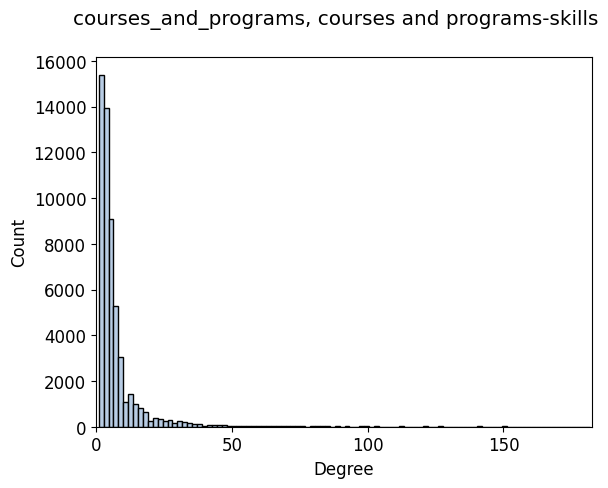

node degree shape courses_and_programs torch.Size([55796, 1])
('courses_and_programs', 'course_qualification', 'qualifications') 
mean tensor(0.0376) 
std tensor(0.7380) 
median tensor(0.) 
max tensor(70.) 
min tensor(0.)
We normalize by max degree


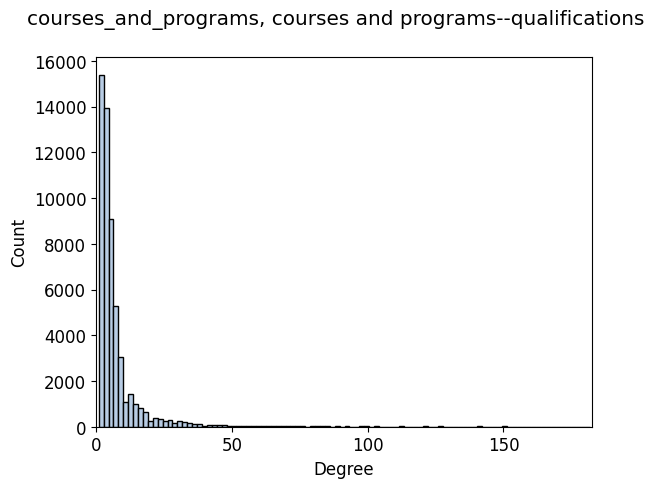

node degree shape courses_and_programs torch.Size([55796, 2])
('courses_and_programs', 'course_and_programs_student', 'people') 
mean tensor(9.9192) 
std tensor(168.0447) 
median tensor(0.) 
max tensor(14890.) 
min tensor(0.)
We normalize by max degree


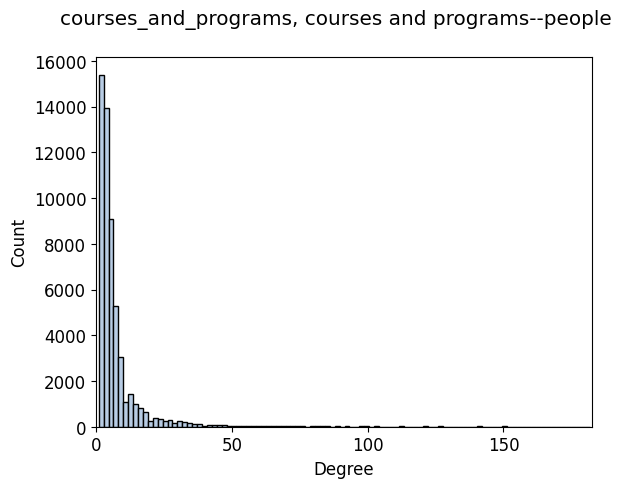

node degree shape courses_and_programs torch.Size([55796, 3])
total_degree 
mean tensor(14.5826) 
std tensor(168.0125) 
median tensor(4.) 
max tensor(14891.) 
min tensor(1.)
We normalize by max degree


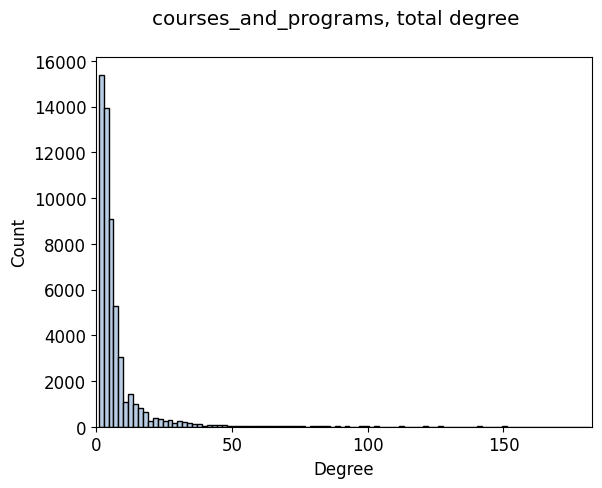

node degree shape courses_and_programs torch.Size([55796, 4])
qualifications
('skills', 'qualification_skill', 'qualifications') 
mean tensor(1.2850) 
std tensor(3.3923) 
median tensor(1.) 
max tensor(52.) 
min tensor(0.)
We normalize by max degree


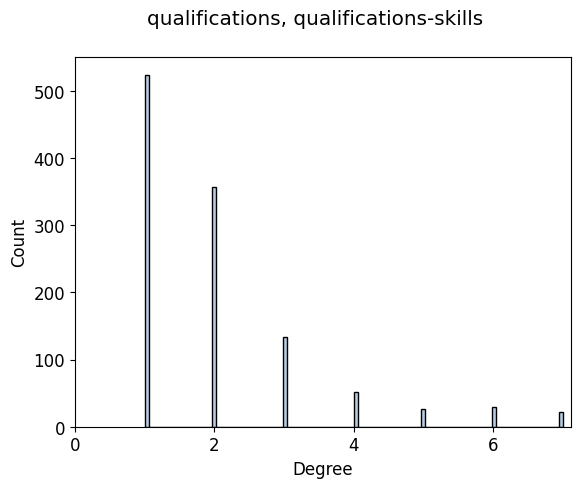

node degree shape qualifications torch.Size([1242, 1])
('courses_and_programs', 'course_qualification', 'qualifications') 
mean tensor(1.6900) 
std tensor(2.3966) 
median tensor(1.) 
max tensor(20.) 
min tensor(0.)
We normalize by max degree


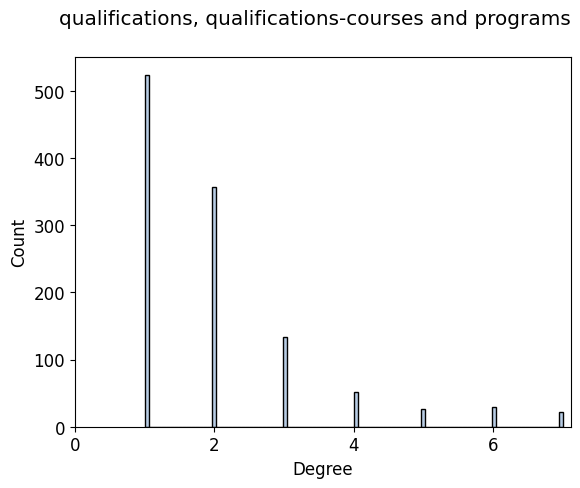

node degree shape qualifications torch.Size([1242, 2])
total_degree 
mean tensor(2.9750) 
std tensor(4.1425) 
median tensor(2.) 
max tensor(52.) 
min tensor(1.)
We normalize by max degree


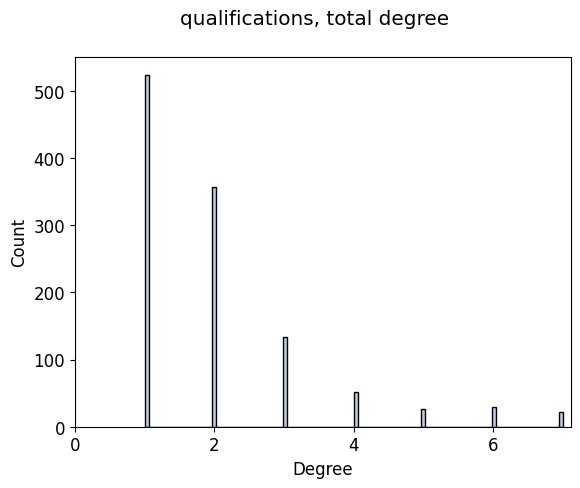

node degree shape qualifications torch.Size([1242, 3])
skills
('skills', 'qualification_skill', 'qualifications') 
mean tensor(0.0115) 
std tensor(0.3045) 
median tensor(0.) 
max tensor(44.) 
min tensor(0.)
We normalize by max degree


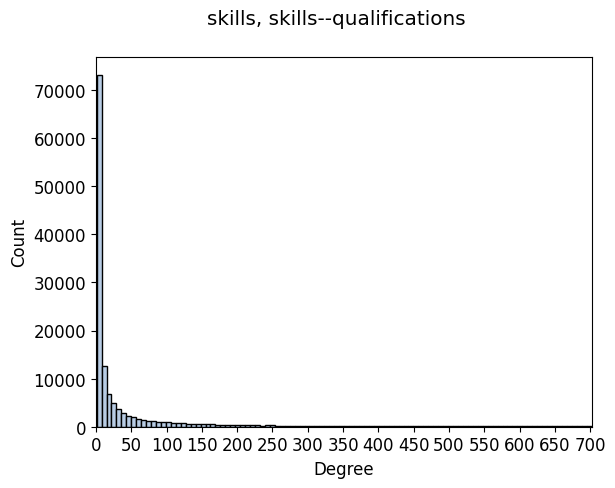

node degree shape skills torch.Size([138698, 1])
('skills', 'course_and_program_skill', 'courses_and_programs') 
mean tensor(1.8609) 
std tensor(15.0299) 
median tensor(0.) 
max tensor(1107.) 
min tensor(0.)
We normalize by max degree


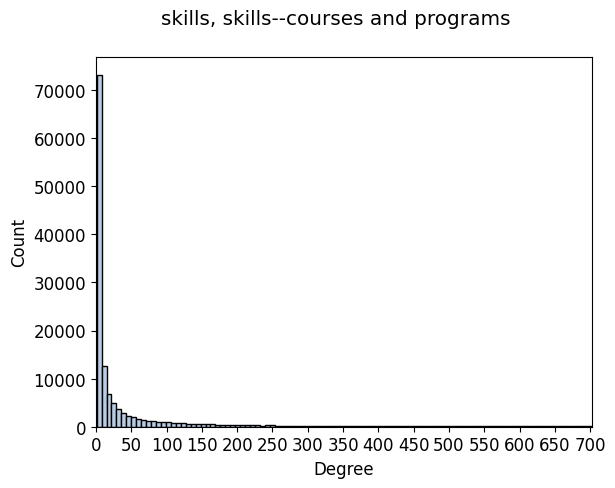

node degree shape skills torch.Size([138698, 2])
('skills', 'job_skill', 'jobs') 
mean tensor(117.4464) 
std tensor(580.6044) 
median tensor(6.) 
max tensor(25440.) 
min tensor(0.)
We normalize by max degree


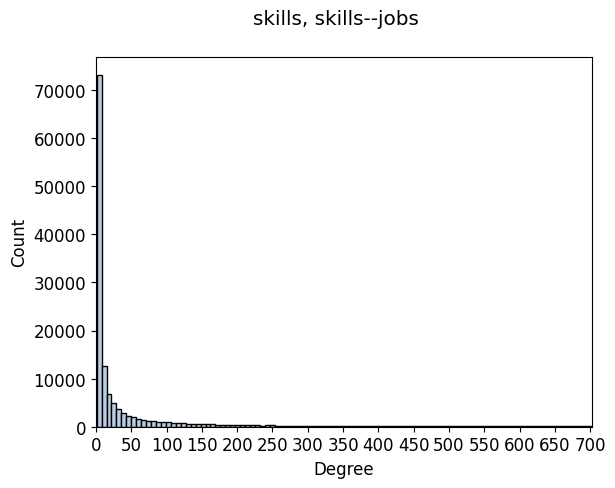

node degree shape skills torch.Size([138698, 3])
total_degree 
mean tensor(119.3188) 
std tensor(583.0842) 
median tensor(7.) 
max tensor(25462.) 
min tensor(1.)
We normalize by max degree


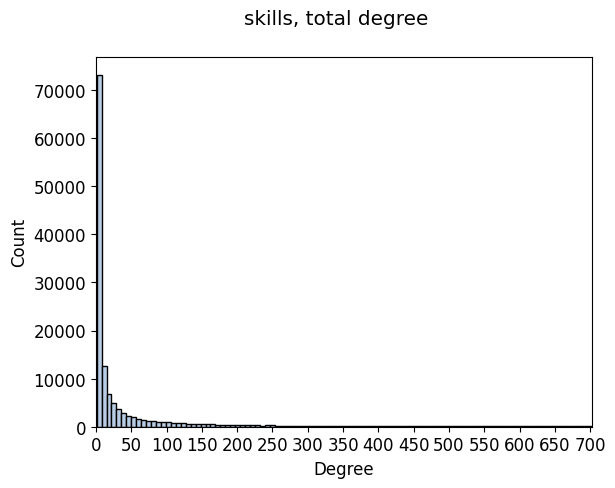

node degree shape skills torch.Size([138698, 4])
people
('courses_and_programs', 'course_and_programs_student', 'people') 
mean tensor(1.8861) 
std tensor(5.7854) 
median tensor(0.) 
max tensor(392.) 
min tensor(0.)
We normalize by max degree


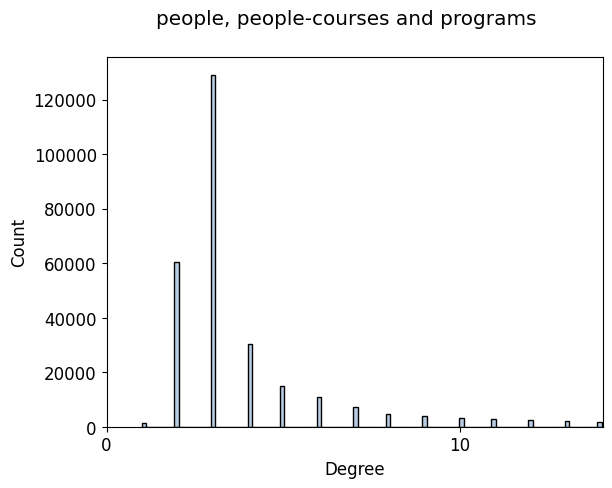

node degree shape people torch.Size([293444, 1])
('jobs', 'job_student', 'people') 
mean tensor(1.) 
std tensor(0.) 
median tensor(1.) 
max tensor(1.) 
min tensor(1.)
We normalize by max degree


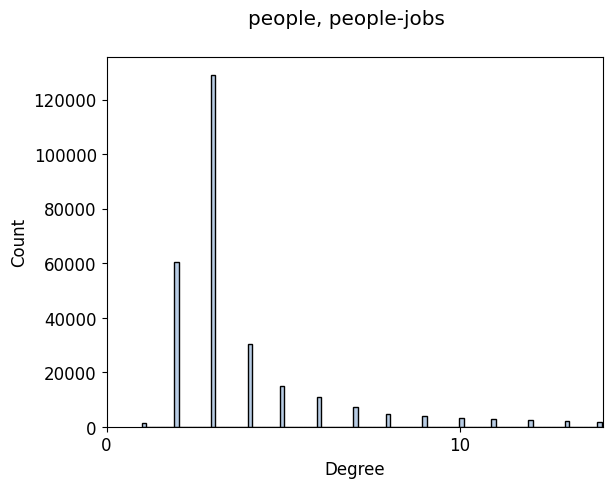

node degree shape people torch.Size([293444, 2])
('people', 'supervisor_supervisee', 'people') 
mean tensor(1.4853) 
std tensor(5.9652) 
median tensor(1.) 
max tensor(1101.) 
min tensor(0.)
We normalize by max degree


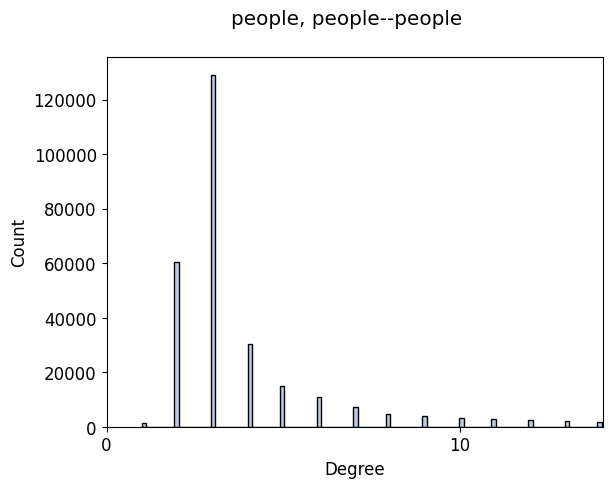

node degree shape people torch.Size([293444, 3])
('people', 'organization_student', 'organizations') 
mean tensor(0.9953) 
std tensor(0.0685) 
median tensor(1.) 
max tensor(1.) 
min tensor(0.)
We normalize by max degree


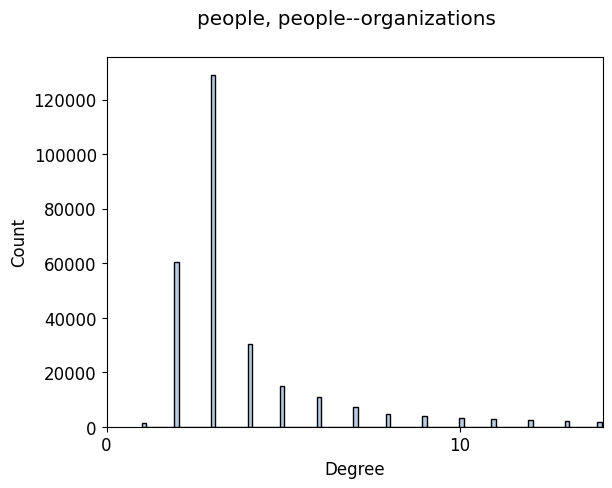

node degree shape people torch.Size([293444, 4])
total_degree 
mean tensor(5.3666) 
std tensor(8.6610) 
median tensor(3.) 
max tensor(1106.) 
min tensor(1.)
We normalize by max degree


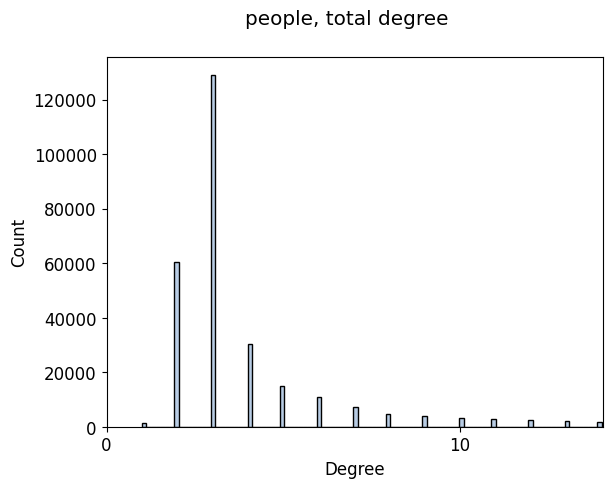

node degree shape people torch.Size([293444, 5])
jobs
('jobs', 'job_student', 'people') 
mean tensor(5.2742) 
std tensor(200.3488) 
median tensor(0.) 
max tensor(36012.) 
min tensor(0.)
We normalize by max degree


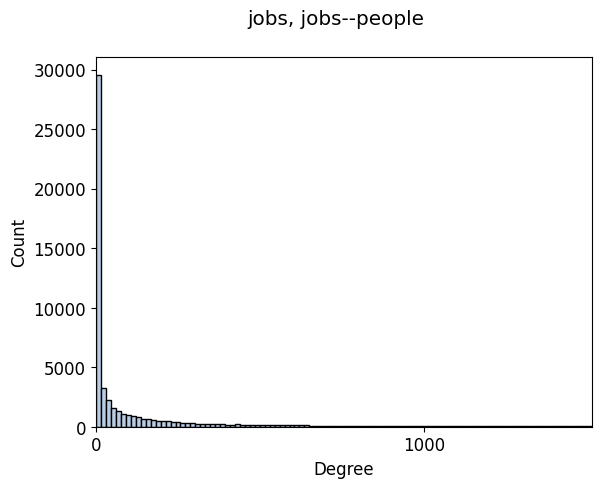

node degree shape jobs torch.Size([55638, 1])
('jobs', 'job_job', 'jobs') 
mean tensor(0.6608) 
std tensor(5.4187) 
median tensor(0.) 
max tensor(126.) 
min tensor(0.)
We normalize by max degree


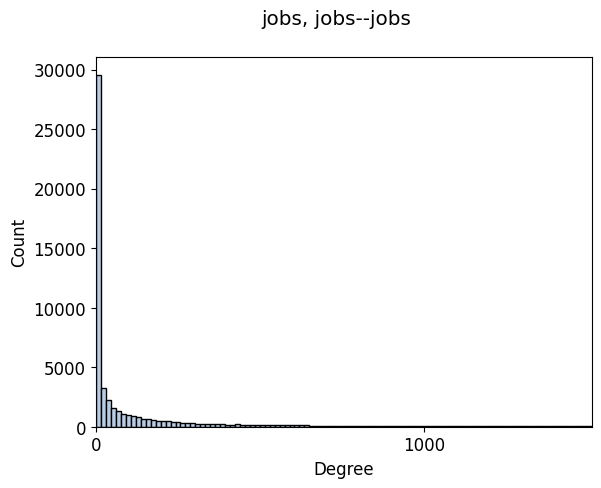

node degree shape jobs torch.Size([55638, 2])
('skills', 'job_skill', 'jobs') 
mean tensor(292.7781) 
std tensor(1186.1764) 
median tensor(9.) 
max tensor(42952.) 
min tensor(0.)
We normalize by max degree


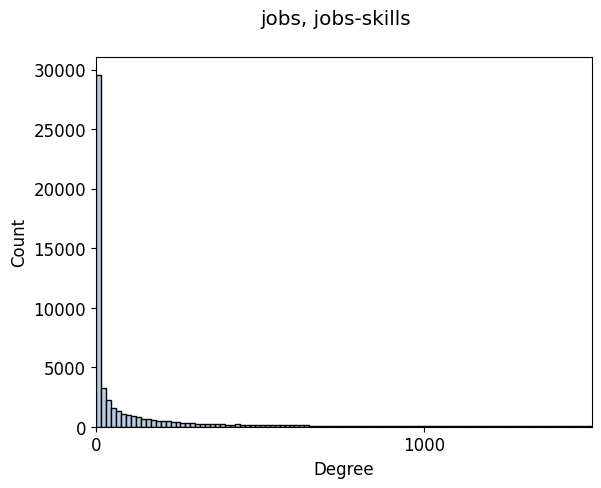

node degree shape jobs torch.Size([55638, 3])
('jobs', 'broader_job_job', 'jobs') 
mean tensor(1.9622) 
std tensor(16.1721) 
median tensor(1.) 
max tensor(2749.) 
min tensor(0.)
We normalize by max degree


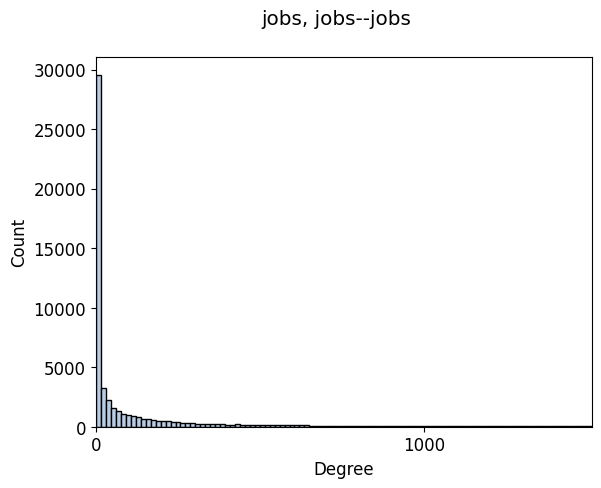

node degree shape jobs torch.Size([55638, 4])
total_degree 
mean tensor(300.6753) 
std tensor(1212.4595) 
median tensor(11.) 
max tensor(43184.) 
min tensor(1.)
We normalize by max degree


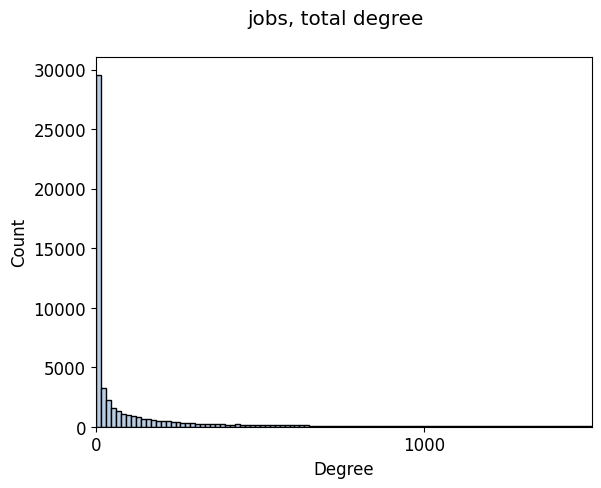

node degree shape jobs torch.Size([55638, 5])
organizations
('people', 'organization_student', 'organizations') 
mean tensor(21.4545) 
std tensor(155.8940) 
median tensor(8.) 
max tensor(17215.) 
min tensor(1.)
We normalize by max degree


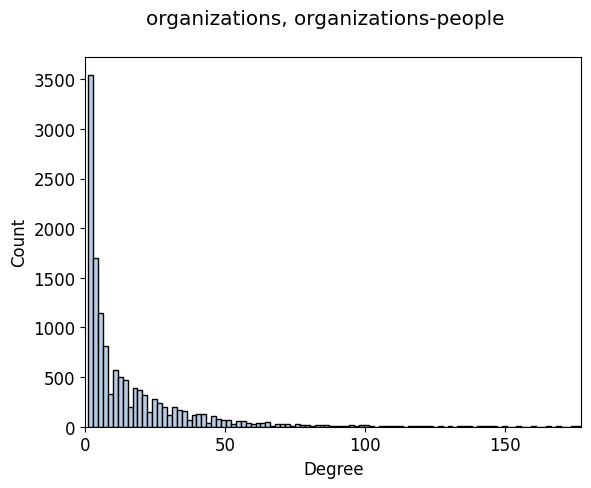

node degree shape organizations torch.Size([13613, 1])
total_degree 
mean tensor(21.4545) 
std tensor(155.8940) 
median tensor(8.) 
max tensor(17215.) 
min tensor(1.)
We normalize by max degree


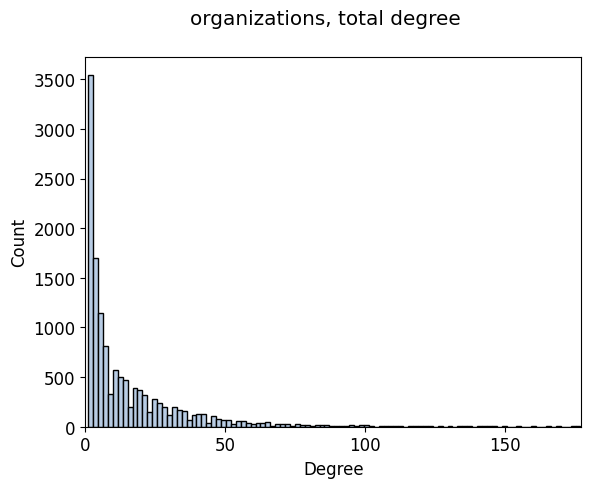

node degree shape organizations torch.Size([13613, 2])


In [35]:

from utils.plot_degree import plot_degree
# add features:
# node degrees
from torch_geometric.utils import to_dense_adj, degree
degrees = {}
for node_type in data.node_types:
    degrees[node_type] = {}
    
for edge_type in data.edge_types:
    if edge_type[0] == edge_type[2]:
        degrees[edge_type[0]][edge_type] = degree(data[edge_type].edge_index.flatten(), num_nodes=data[edge_type[0]].num_nodes)
    else:
        degrees[edge_type[0]][edge_type] = degree(data[edge_type].edge_index[0], num_nodes=data[edge_type[0]].num_nodes)
        degrees[edge_type[2]][edge_type] = degree(data[edge_type].edge_index[1], num_nodes=data[edge_type[2]].num_nodes)

# for each node type, add the degrees of all edge types and append it as 'total_degree' to the degrees dict
for node_type in data.node_types:
    degrees[node_type]['total_degree'] = torch.zeros(data[node_type].num_nodes)
    for edge_type in degrees[node_type]:
        if edge_type != 'total_degree':
            degrees[node_type]['total_degree'] += degrees[node_type][edge_type] 

# for each node type print degree statistics for each edge type, and the total degree, max, min, mean, median. Also make a small degree plot
for node_type in data.node_types:
    print(node_type)
    # create empty torch array with length of nodes
    node_degrees = None
    
    for edge_type in degrees[node_type]:
        print(edge_type, '\nmean',degrees[node_type][edge_type].mean(), '\nstd',degrees[node_type][edge_type].std(), '\nmedian',degrees[node_type][edge_type].median(),'\nmax', degrees[node_type][edge_type].max(),'\nmin', degrees[node_type][edge_type].min())
        print('We normalize by max degree')
        #smaller figure
        x = degrees[node_type]['total_degree'].numpy()
        if node_type == edge_type[0]:
            title_ = f'{node_type}, {" ".join(edge_type[0].split("_"))}--{" ".join(edge_type[2].split("_"))}'
            save_file_ = f'{node_type}__{" ".join(edge_type[0].split("_"))}_{" ".join(edge_type[2].split("_"))}.png'
        elif edge_type == 'total_degree':
            title_ = f'{node_type}, total degree'
            save_file_ = f'{node_type}__total_degree.png'
        else:
            title_ = f'{node_type}, {" ".join(edge_type[2].split("_"))}-{" ".join(edge_type[0].split("_"))}'
            save_file_ = f'{node_type}__{" ".join(edge_type[2].split("_"))}_{" ".join(edge_type[0].split("_"))}.png'
            
            
        plot_degree(x, title_, 'Degree', 'Count', 'plot_images/'+save_file_, savefig=True, xlim=[0, np.mean(x)+np.std(x)*1], color='#b8cce4')
        
        maximum = degrees[node_type][edge_type].max()
        if node_degrees is None:
            node_degrees = (degrees[node_type][edge_type]/maximum).unsqueeze(1)
        else:
            node_degrees = torch.cat((node_degrees, (degrees[node_type][edge_type]/maximum).unsqueeze(1)), dim=1)
            
        print('node degree shape',node_type, node_degrees.shape)
        
    if 'x' in data[node_type].keys():
        data[node_type].x = torch.cat((data[node_type].x, node_degrees), dim=1)
    else:
        data[node_type].x = node_degrees
        
   

In [36]:
from torch_sparse import SparseTensor
from tqdm.auto import tqdm
import torch
import gc
from torch_geometric.utils import is_undirected


def triangle_count(adj_matrix:SparseTensor):
    # block wise triangle count, to avoid memory issues
    diags = []
    
    row_block_size = 10
    rows = adj_matrix.size(0)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print('using',device)
    with torch.no_grad():
        
        adj_matrix = adj_matrix.to(device)
        for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
            torch.cuda.empty_cache()
            gc.collect()
            start = block
            end = min(block+row_block_size, rows)
            adj_pow_3_block = adj_matrix[start:end].spspmm(adj_matrix).spspmm(adj_matrix)
            diag_block = get_diag(adj_pow_3_block[:,start:]).cpu()
            diags.append(diag_block)

    
    return 1/2 * torch.cat(diags, dim=0)
        
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
from torch_sparse.diag import get_diag

def undirected_triangle_counts(edge_index, max_num_nodes): 
    """Get triangles **per node**, to get count for whole graph, divide by 3"""
    
    if not is_undirected(edge_index):
        print('converting edge index to undirected')
        edge_index = to_undirected(edge_index)
    
    adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], value=torch.ones(edge_index[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))
    triangles = triangle_count(adj_matrix) 
    return triangles

In [37]:
# for edge types where both ends are the same node type, add the triangle count for the node
import torch 

for edge_type in data.edge_types:
    if edge_type[0] == edge_type[2]:
        print('add triangles to', edge_type[0])
        # if file already in pickle, load from pickle, folder is precomputed_triangles
        pickle_path = 'precomputed_triangles/'+edge_type[0]+'_'+('_'.join(edge_type))+'.pt'
        if os.path.exists(pickle_path):
            triangles = torch.load(pickle_path)
        else:
            triangles = undirected_triangle_counts(data[edge_type].edge_index, data[edge_type[0]].num_nodes)
            torch.save(triangles, pickle_path)
            
        print(edge_type[0], 'triangles', '\nmean', triangles.mean(),'\nstd', triangles.std(), '\nmedian',triangles.median(), '\nmax',triangles.max(), '\nmin',triangles.min())
        
        if 'x' in data[edge_type[0]].keys():
            data[edge_type[0]].x = torch.cat([data[edge_type[0]].x, triangles.unsqueeze(1)], dim=1)
        else:
            data[edge_type[0]].x = triangles.unsqueeze(1)
            


print('add homogeneous triangles')
homogeneous_data = data.to_homogeneous()
if os.path.exists('precomputed_triangles/homogeneous.pt'):
    homogenous_triangles = torch.load('precomputed_triangles/homogeneous.pt')
else:
    homogenous_triangles = undirected_triangle_counts(homogeneous_data.edge_index, homogeneous_data.num_nodes)
    torch.save(homogenous_triangles, 'precomputed_triangles/homogeneous.pt')
    
print('homogeneous triangles', '\nmean', homogenous_triangles.mean(),'\nstd', homogenous_triangles.std(), '\nmedian',homogenous_triangles.median(), '\nmax',homogenous_triangles.max(), '\nmin',homogenous_triangles.min())

for i in range(len(data.node_types)):
    mask =  homogeneous_data.node_type == i
    
    if 'x' in data[node_type].keys():
        data[node_type].x = torch.cat([data[node_type].x, triangles[mask].unsqueeze(1)], dim=1)
    else:
        data[node_type].x = triangles[mask].unsqueeze(1)



add triangles to people
people triangles 
mean tensor(0.) 
std tensor(0.) 
median tensor(0.) 
max tensor(0.) 
min tensor(0.)
add triangles to jobs
jobs triangles 
mean tensor(2.8896) 
std tensor(27.4987) 
median tensor(0.) 
max tensor(1284.) 
min tensor(0.)
add triangles to jobs
jobs triangles 
mean tensor(0.) 
std tensor(0.) 
median tensor(0.) 
max tensor(0.) 
min tensor(0.)
add homogeneous triangles
converting edge index to undirected
using cuda


blockwise sparse matrix-multiplication:   0%|          | 79/55844 [03:58<46:45:12,  3.02s/it]


KeyboardInterrupt: 

In [ ]:
data = T.ToUndirected(merge=False)(data)

In [ ]:
import os
import torch
from torch_geometric.data import HeteroData


filename = 'HeteroData_Learnings_v1.pt'
if os.path.exists('./'+filename):
    # data = HeteroData.from_dict(torch.load('./'+filename))
    raise Exception('File already exists')
else:
    torch.save(dataT.to_dict(), './'+filename)

In [ ]:
# END

wadawdwa

In [ ]:
data['courses_and_programs']

In [ ]:
# drop all text columns

In [ ]:
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.HGTConv.html


In [ ]:
wdwd

In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()
data['Skill'].x = torch.tensor(skill_sbert_embeddings)
data['Job'].x = torch.tensor(job_sbert_embeddings)

data['Job','REQUIRES','Skill'].edge_index = torch.tensor(skill_job_edges[['job_src','skill_dst']].to_numpy().T)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index = torch.tensor(skill_skill_edges[['skill_src','skill_dst']].to_numpy().T)
data['Job','IS_SIMILAR_JOB','Job'].edge_index = torch.tensor(job_job_edges[['job_src','job_dst']].to_numpy().T)


data['Job','REQUIRES','Skill'].edge_weight = torch.tensor(skill_job_edges['normalized_tfidf']).to(torch.float)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_weight = torch.tensor(skill_skill_edges['cosine_sim_score'].to_numpy()).to(torch.float)
data['Job','IS_SIMILAR_JOB','Job'].edge_weight = torch.tensor(job_job_edges['relatedness_weight'].to_numpy()).to(torch.float)

In [ ]:
# map 3,6,7,3,3,... to 1,2,3,1,1 ...
skillmapping ={}
for i,skill in enumerate(skill_nodes.skill.unique()):
    skillmapping[skill] =i

jobmapping ={}
jobmapping_index_to_title_alttile = {}
for i, index in enumerate(job_nodes['index'].unique()):
    jobmapping[index] =i

for _, row in job_nodes.iterrows():
    if type(row['Title']) == str:
        a = row['Title']
    else:
        a = ''
    
    jobmapping_index_to_title_alttile[row['index']] = (a+' / '+row['Alternate Title']).strip('/')

inverted_skillmapping = {v:k for k,v in skillmapping.items()}
inverted_jobmapping = {v:k for k,v in jobmapping.items()}

In [ ]:
skill_job_edges['skill_dst'] = skill_job_edges['skill'].apply(lambda x:skillmapping[x])
skill_job_edges['job_src'] = skill_job_edges['alt_title'].apply(lambda x:jobmapping[x])

In [ ]:
# normalization and removal of job-skill edges
# first group by jobs and limit the skills for each job to 175
# then normalize those tfidf edgeweights
# then group by skill and limit edges to 125 for skills (ordered by normalized tf-idf)
skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(200,'scaled_tfidf')).reset_index(drop=True)
summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()
skill_job_edges['sum'] = skill_job_edges['job_src'].apply(lambda x: summed_tfidf_per_job.loc[x]['scaled_tfidf'])
skill_job_edges['normalized_tfidf'] =  skill_job_edges['scaled_tfidf']/skill_job_edges['sum']
skill_job_edges = skill_job_edges.groupby('skill_dst').apply(lambda group: group.nlargest(200,'normalized_tfidf')).reset_index(drop=True)
# we dont do the second round of normalization

In [ ]:
# normalization and removing of skill-skill edges


In [ ]:


#for each alt title select the first 125 skill_job edges, ordered by tfidf
# skill_job_edges = skill_job_edges.groupby('job_src')
# skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

# for each skill only use the 125 edges with the highest tf-idf score
#skill_job_edges = skill_job_edges.groupby('skill').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

In [ ]:
skill_job_edges

In [ ]:
onet_alttitles = pd.read_csv('neo4jgraph/onet_alt_titles_unique.csv')
del onet_alttitles['Unnamed: 0']

In [ ]:
onet_alttitle_str_mapping = {}
for i,row in onet_alttitles.iterrows():
    onet_alttitle_str_mapping[row['index']] = row['Alternate Title']

In [ ]:
import torch
mappings = {
    'onet_alttitle_str_mapping':onet_alttitle_str_mapping,
    'skillmapping':skillmapping,
    'inverted_skillmapping':inverted_skillmapping,
    'jobmapping':jobmapping,
    'inverted_jobmapping':inverted_jobmapping,
    'jobmapping_index_to_title_alttile':jobmapping_index_to_title_alttile
}

torch.save(mappings, 'Job_Skill_HeteroData_name_mappings_withdupes_fulldataset_v2.pt')

In [ ]:
len(jobmapping.keys())

In [ ]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
skill_sbert_embeddings = embedder.encode(skill_nodes['skill'].tolist(), convert_to_numpy=True, device='cuda')
job_sbert_embeddings = embedder.encode(job_nodes['Alternate Title'].tolist(), convert_to_numpy=True, device='cuda')

In [ ]:
# add job-job edges, dataset see https://www.onetcenter.org/dictionary/26.3/excel/related_occupations.html
job_job_edges = pd.read_csv('neo4jgraph/onet_related_occupations.csv')

In [ ]:
job_job_edges

In [ ]:
job_job_edges['job_src'] = job_job_edges['index_x'].apply(lambda x: jobmapping[x])
job_job_edges['job_dst'] = job_job_edges['index_y'].apply(lambda x: jobmapping[x])
relatedness_weight = {
    'Supplemental':0.5,
    'Primary-Long':0.75,
    'Primary-Short':1
}
job_job_edges['relatedness_weight'] = job_job_edges['Relatedness Tier'].apply(lambda x: relatedness_weight[x])

In [ ]:
skill_skill_edges = pd.read_csv('neo4jgraph/skill_skill_edges.csv')


In [ ]:
#filter out potentially bad skills (which are not in our original skillmapping)
skill_skill_edges = skill_skill_edges.loc[(skill_skill_edges.skill.isin(list(skillmapping.keys()))) & (skill_skill_edges.related_skill.isin(list(skillmapping.keys())))]

In [ ]:
skill_skill_edges['skill_src'] = skill_skill_edges['skill'].apply(lambda x: skillmapping[x])
skill_skill_edges['skill_dst'] = skill_skill_edges['related_skill'].apply(lambda x: skillmapping[x])

In [ ]:
# # only take largest 125 "both directions" (not ideal)
# skill_skill_edges =  skill_skill_edges.groupby('skill_src').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)
# skill_skill_edges =  skill_skill_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)

In [ ]:
# get normalized tfidf boxplot using matplotlib
import matplotlib.pyplot as plt
plt.boxplot(skill_job_edges['normalized_tfidf'])
plt.show()

# get count of skills outside the boxplot
len(skill_job_edges.loc[skill_job_edges['normalized_tfidf']>0.1])

In [ ]:
import matplotlib.pyplot as plt

plt.hist(a, bins=100)
plt.show()
plt.hist(skill_skill_edges['cosine_sim_score'].to_numpy(), bins=100)
plt.show()
plt.hist(job_job_edges['relatedness_weight'].to_numpy(), bins=100)

# change all values over 

In [ ]:
# recscale to interval 0.5-1
a = skill_job_edges['normalized_tfidf'].copy()
a[a>0.08] = 0.08
a = (a-a.min())/(a.max()-a.min())
# rescale to interval 0.5-1
a = (a*0.5)+0.5
skill_job_edges['normalized_tfidf'] = a

In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()
data['Skill'].x = torch.tensor(skill_sbert_embeddings)
data['Job'].x = torch.tensor(job_sbert_embeddings)

data['Job','REQUIRES','Skill'].edge_index = torch.tensor(skill_job_edges[['job_src','skill_dst']].to_numpy().T)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index = torch.tensor(skill_skill_edges[['skill_src','skill_dst']].to_numpy().T)
data['Job','IS_SIMILAR_JOB','Job'].edge_index = torch.tensor(job_job_edges[['job_src','job_dst']].to_numpy().T)


data['Job','REQUIRES','Skill'].edge_weight = torch.tensor(skill_job_edges['normalized_tfidf']).to(torch.float)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_weight = torch.tensor(skill_skill_edges['cosine_sim_score'].to_numpy()).to(torch.float)
data['Job','IS_SIMILAR_JOB','Job'].edge_weight = torch.tensor(job_job_edges['relatedness_weight'].to_numpy()).to(torch.float)

In [ ]:
# Look at node degree statistics

from torch_geometric.utils import to_dense_adj, degree



job_n = data['Job'].x.shape[0]
skill_n = data['Skill'].x.shape[0]

JRS_J = degree(data['Job','REQUIRES','Skill'].edge_index[0], num_nodes=job_n)
JRS_S = degree(data['Job','REQUIRES','Skill'].edge_index[1], num_nodes=skill_n)
S_SIM_S = degree(data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.flatten(), num_nodes=skill_n)
J_SIM_J = degree(data['Job','IS_SIMILAR_JOB','Job'].edge_index.flatten(), num_nodes=job_n)

actual_skill_n = torch.nonzero(JRS_S+S_SIM_S).shape[0] # only skills which have any edge at all
actual_job_n = torch.nonzero(JRS_J+J_SIM_J).shape[0] # only job which have any edge at all
print(f'Jobs: {job_n}, actual Jobs used (in at least one edge): {actual_job_n}')
print(f'Skills: {skill_n}, actual Skills used (in at least one edge): {actual_skill_n}')

print('\nFollowing metrics only include Skills and Jobs with at least one edge:\n')

print(f"JRS edges: {data['Job','REQUIRES','Skill'].edge_index.shape[1]}")
print(f'Average JRS Job degree: {torch.sum(JRS_J)/actual_job_n}, Skill: {torch.sum(JRS_S)/actual_skill_n}')
print(f'Median JRS Job degree: {torch.median(JRS_J[JRS_J!=0])}, Skill: {torch.median(JRS_S[JRS_S!=0])}')
print(f'Max JRS Job degree: {torch.max(JRS_J)}, Skill: {torch.max(JRS_S)}\n')

print(f"S_SIM_S edges: {data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.shape[1]}")
print(f'Average S_SIM_S degree: {torch.sum(S_SIM_S)/actual_skill_n}')
print(f'Median S_SIM_S degree: {torch.median(S_SIM_S[S_SIM_S!=0])}')
print(f'Max S_SIM_S degree: {torch.max(S_SIM_S)}')

print(f'J_SIM_J edges: {data["Job", "IS_SIMILAR_JOB", "Job"].edge_index.shape[1]}')
print(f'Average J_SIM_J degree: {torch.sum(J_SIM_J)/actual_job_n}')
print(f'Median J_SIM_J degree: {torch.median(J_SIM_J[J_SIM_J!=0])}')
print(f'Max J_SIM_J degree: {torch.max(J_SIM_J)}\n')

print(f'Average total degree: Job: {(torch.sum(JRS_J)+torch.sum(J_SIM_J))/actual_job_n}')
print(f'Average total degree: Skill: {(torch.sum(JRS_S)+torch.sum(S_SIM_S))/actual_skill_n}')

import matplotlib.pyplot as plt
import os 

os.makedirs("plot_images/", exist_ok=True)

# Plot and save the first plot
plt.title('J-R-S Job degree-distribution')
plt.hist(JRS_J[JRS_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_J_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the second plot
plt.title('J-R-S Skill degree-distribution')
plt.hist(JRS_S[JRS_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_S_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the third plot
plt.title('S-R-S Skill degree')
plt.hist(S_SIM_S[S_SIM_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/S_SIM_S_skill_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the fourth plot
plt.title('J-R-J Job degree')
plt.hist(J_SIM_J[J_SIM_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/J_SIM_J_job_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

In [ ]:
# Add features:
# - node degree
# - normalize edge weights by node degree
# - (triangle count)


# add node degree statistics:

job_degrees = torch.cat((JRS_J.reshape(-1,1) / 125, J_SIM_J.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees
skill_degrees = torch.cat((JRS_S.reshape(-1,1) / 125, S_SIM_S.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees

data['Job'].x = torch.cat((data['Job'].x, job_degrees), dim=1)
data['Skill'].x = torch.cat((data['Skill'].x, skill_degrees), dim=1)

# normalize edge weights by node degree

In [ ]:
from torch_sparse import SparseTensor
from tqdm.auto import tqdm
import torch
import gc
# adj_matmul
# row1 to rowS * full_matrix
# rowS+1 to rowT * full_matrix
# ....

# def blockwise_sparse_square_mmul(adj_matrix, blocks=None):
#     row_blocks = []
    
#     if blocks is None:
#         row_block_size = 10000
#         rows = adj_matrix.size(0)
#         for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
#             start = block
#             end = min(block+row_block_size, rows)
#             row_blocks.append(adj_matrix[start:end].spspmm(adj_matrix))
#     else:
#         for block in tqdm(blocks, desc='blockwise sparse matrix-multiplication'):
#             row_blocks.append(block.spspmm(adj_matrix))

#     return row_blocks


# def blockwise_sparse_get_diag(blocks):
#     diags = []
#     for block in tqdm(blocks, desc='get blockwise sparse matrix diagonal'):
#         diags.append(get_diag(block))
    
#     return torch.cat(diags, dim=0)

def triangle_count(adj_matrix:SparseTensor):
    # adj_matmul, blockwise, so kernel does not crash
    # diag1((row1 to rowS) * full_matrix * full_matrix)
    # diag2((rowS+1 to rowR) * full_matrix * full_matrix)
    # ....
    diags = []
    
    row_block_size = 400
    rows = adj_matrix.size(0)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)
    with torch.no_grad():
        
        adj_matrix = adj_matrix.to(device)
        for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
            torch.cuda.empty_cache()
            gc.collect()
            start = block
            end = min(block+row_block_size, rows)
            adj_pow_3_block = adj_matrix[start:end].spspmm(adj_matrix).spspmm(adj_matrix)
            diag_block = get_diag(adj_pow_3_block[:,start:].cpu()).cpu()
            diags.append(diag_block)
            # diag = torch.eye(end)
            # indices_i, indices_j = diag.nonzero().unbind(dim=1)
            
            # A = adj_pow_2_block[indices_i]
            # B = adj_matrix[:, indices_j]
            # print(A, t(B))
            # print(type(B), type(A))
            # print(A.size(0), A.size(1), B.size(0), B.size(1))
            #C = A * t(B)
            #C = reduction(C, dim=1)
            
           
            #print(C)
            
            
            
    
    return 1/2 * torch.cat(diags, dim=0)
        
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
from torch_sparse.diag import get_diag

def undirected_triangle_counts(edge_index, max_num_nodes): 
    """Get triangles **per node**, to get count for whole graph, divide by 3"""
    ud = to_undirected(edge_index)
    
    adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_csr_tensor(ud[0], ud[1], values=torch.ones(ud[1].shape[0]), dtype=torch.float32).to_sparse_coo()
    triangles = triangle_count(adj_matrix) 
    return triangles

In [ ]:
# from torch_sparse import SparseTensor
# adj = torch.tensor(
#     [
#         [0,1,1,1,1],
#         [1,0,1,0,1],
#         [1,1,0,1,0],
#         [1,0,1,0,1],
#         [1,1,0,1,0]
#     ]
# ).to(torch.float)
# X = SparseTensor.from_dense(adj)
# triangles = triangle_count(X)
# triangles
#adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))

In [ ]:
homogeneous_data = data.to_homogeneous()
homogenous_triangles = undirected_triangle_counts(homogeneous_data.edge_index, homogeneous_data.x.shape[0])
# max triangles: 9000


In [ ]:
Job_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type == 1]
Skill_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type != 1]

In [ ]:
actual_s_triangles = Skill_homogeneous_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = Job_homogeneous_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

In [ ]:
plt.title('Skill triangles')
plt.hist(actual_s_triangles.numpy(), bins=40)
plt.show()
plt.title('Job triangles')
plt.hist(actual_j_triangles.numpy(), bins=40)
plt.show()

In [ ]:
data

In [ ]:
J_SIM_J_triangles = undirected_triangle_counts(data['Job','IS_SIMILAR_JOB', 'Job'].edge_index, data['Job'].x.shape[0])
S_SIM_S_triangles = undirected_triangle_counts(data['Skill','IS_SIMILAR_SKILL', 'Skill'].edge_index, data['Skill'].x.shape[0])

In [ ]:
actual_s_triangles = S_SIM_S_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = J_SIM_J_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes for skill-skill edges: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes for job-job edges: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

In [ ]:
Skill_homogeneous_triangles.max(), Job_homogeneous_triangles.max(), S_SIM_S_triangles.max(), J_SIM_J_triangles.max()

In [ ]:
data['Skill'].x = torch.cat((data['Skill'].x, Skill_homogeneous_triangles.reshape(-1,1)/65380), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, Job_homogeneous_triangles.reshape(-1,1)/2059), dim=1) # normalize by max 1320

data['Skill'].x = torch.cat((data['Skill'].x, S_SIM_S_triangles.reshape(-1,1)/65380), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, J_SIM_J_triangles.reshape(-1,1)/1284), dim=1) # normalize by max 1320

In [ ]:
data.has_isolated_nodes(), data.has_self_loops()

In [ ]:
#data = data.to(device)

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([
       #T.RemoveIsolatedNodes(),
       T.RemoveDuplicatedEdges(),
       T.ToUndirected(merge=False) # don't merge reversed edges into the original edge type
])

data = transform(data)


In [ ]:
# torch.save(data.to_dict(), path)
# data = Data.from_dict(torch.load(path))

In [ ]:
import os
import torch
from torch_geometric.data import HeteroData


filename = 'Job_Skill_HeteroData_withdupes_fulldataset_v2.pt'
if os.path.exists('./'+filename):
    # data = HeteroData.from_dict(torch.load('./'+filename))
    raise Exception('File already exists')
else:
    torch.save(data.to_dict(), './'+filename)